In [1]:
import audio_dspy as adsp
import matplotlib as mpl
import matplotlib.pyplot as plt
import wavio

#debugging
import numpy as np
import scipy.stats as stats

In [2]:
def find_freqs(x, fs, thresh=30, above=0, frac_off=0.1, plot=False):
    """
    Find the mode frequencies of a signal
    Parameters
    ----------
    x : ndarray
        signal to analyze
    fs : float
        sample rate of the signal
    thresh : float, optional
        threshold to use for finding modes [dB]
    above : float, optional
        lower limit frequency to look for modes
    frac_off : float, optional
        to avoid finding multiple peaks for the same mode,
        this parameter defines a fractional offset for
        frequency breaks between modes
    plot : bool, optional
        should plot this analysis
    Returns
    -------
    freqs : ndarray
        Mode frequencies [Hz]
    peaks : ndarray
        Mode magnitudes [gain]
    """
    X = np.fft.rfft(x)
    f = np.linspace(0, fs/2, num=len(X))

    X_freqs = []
    X_peaks = []
    for k in range(len(X)):
        # check if above thresh
        Mag = 20 * np.log10(np.abs(X[k]))
        if (Mag < thresh):
            continue

        # check if within frac_off of a larger peak
        k_test = k
        flag = 0
        while (k_test < (len(X) - 1)) and (f[k_test] < f[k] * (1 + frac_off)):
            k_test += 1
            if 20*np.log10(np.abs(X[k_test])) > Mag:
                flag = 1
                break

        k_test = k
        while(f[k_test] > f[k] * (1 - frac_off)):
            k_test -= 1
            if 20*np.log10(np.abs(X[k_test])) > Mag:
                flag = 1
                break

        if flag == 1:
            continue

        # if above lower limit
        if (f[k] > above):
            X_freqs.append(f[k])
            X_peaks.append(np.abs(X[k]))

    # plot if needed
    if plot:
        plt.semilogx(f, 20 * np.log10(np.abs(X)))
        for freq in X_freqs:
            plt.axvline(freq, color='r')
        plt.ylabel('Magnitude [dB]')
        plt.xlabel('Frequency [Hz]')

    return np.asarray(X_freqs), np.asarray(X_peaks)

In [9]:
def get_dampings(path, plot=False):
    clip = wavio.read(path)
    freqs = find_freqs(clip.data[:, 0], clip.rate, above=20, thresh=90, frac_off=0.1, plot=False)[0]
    
    x = clip.data[:, 0]
    fs = clip.rate
    filt_width=20
    thresh=-40
    eta=0.01
    taus = []
    tau_freqs = []
    for freq in freqs[1:]:
        x_filt = adsp.filt_mode(x, freq, fs, filt_width)
        env = adsp.normalize(adsp.energy_envelope(x_filt, fs, eta))

        top = int(np.argmax(20 * np.log10(env)))
        noise_floor = np.max(20 * np.log10(env[int(len(env)*0.9):]))
        top_val = 20 * np.log10(env[top])
        start = int(np.argwhere(20 * np.log10(env[top:]) < (noise_floor + (top_val-noise_floor) * 0.9))[0]) + top
        end = int(np.argwhere(20 * np.log10(env[start:]) < (noise_floor + (top_val-noise_floor) * 0.1))[0]) + start
        if end <= start:
            continue
        slope, _, _, _, _ = stats.linregress(
            np.arange(len(env[start:end])), 20 * np.log10(env[start:end]))

        gamma = 10**(slope/20)
        tau = -1 / np.log(gamma)
        taus.append(tau)
        tau_freqs.append(freq)
        
        if plot:
            plt.figure()
            plt.title('Decay model for mode = {0:.2f} Hz'.format(freq))
            n = np.arange(len(env))
            plt.plot(n / fs, 20*np.log10(x_filt))
            plt.plot(n / fs, 20*np.log10(env))
            plt.plot(n / fs, 20*np.log10(np.exp(-1.0 * n / tau)), color='r')
            plt.xlabel('Time [s]')
            plt.ylim(thresh * 2, 5)

    return 1./np.array(taus), np.array(tau_freqs)

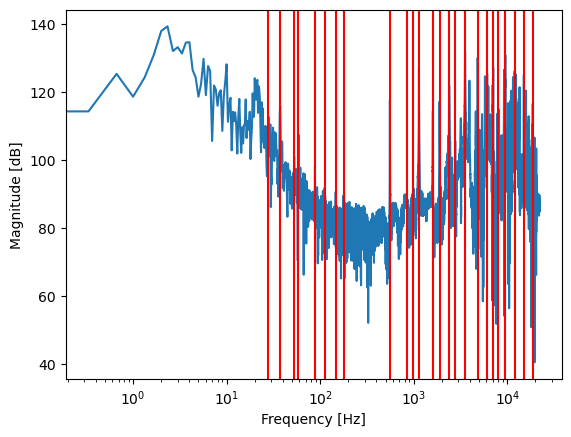

<ipython-input-9-b782da5f96c9>:35: RuntimeWarning: invalid value encountered in log10
  plt.plot(n / fs, 20*np.log10(x_filt))
<ipython-input-9-b782da5f96c9>:35: RuntimeWarning: invalid value encountered in log10
  plt.plot(n / fs, 20*np.log10(x_filt))
<ipython-input-9-b782da5f96c9>:35: RuntimeWarning: invalid value encountered in log10
  plt.plot(n / fs, 20*np.log10(x_filt))
<ipython-input-9-b782da5f96c9>:35: RuntimeWarning: invalid value encountered in log10
  plt.plot(n / fs, 20*np.log10(x_filt))
<ipython-input-9-b782da5f96c9>:35: RuntimeWarning: invalid value encountered in log10
  plt.plot(n / fs, 20*np.log10(x_filt))
<ipython-input-9-b782da5f96c9>:35: RuntimeWarning: invalid value encountered in log10
  plt.plot(n / fs, 20*np.log10(x_filt))
<ipython-input-9-b782da5f96c9>:35: RuntimeWarning: invalid value encountered in log10
  plt.plot(n / fs, 20*np.log10(x_filt))
<ipython-input-9-b782da5f96c9>:35: RuntimeWarning: invalid value encountered in log10
  plt.plot(n / fs, 20*np.log10(x

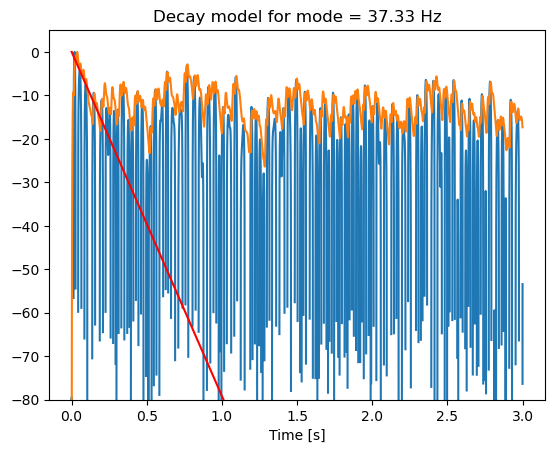

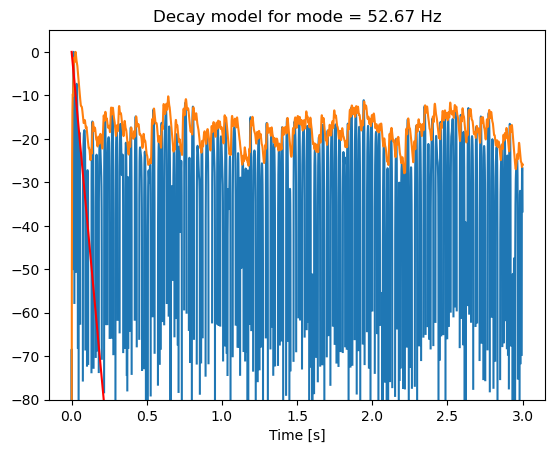

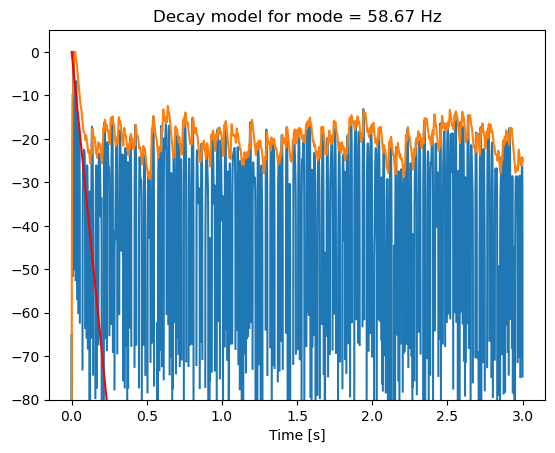

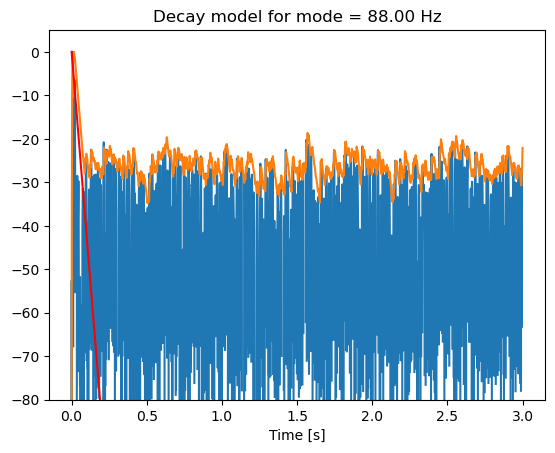

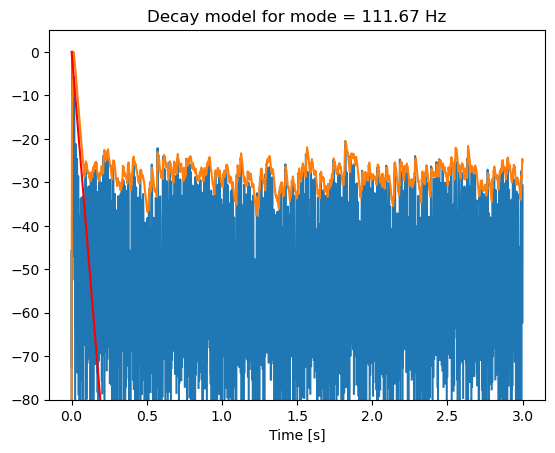

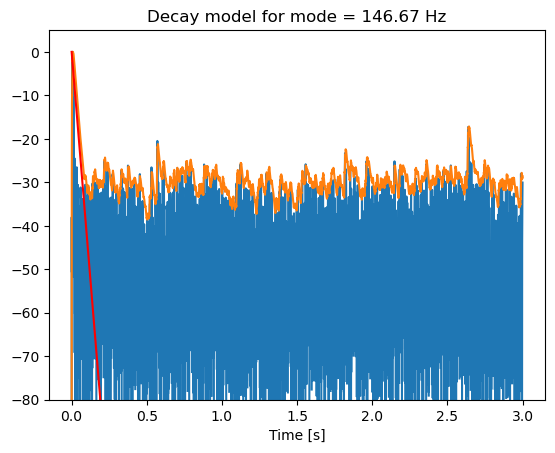

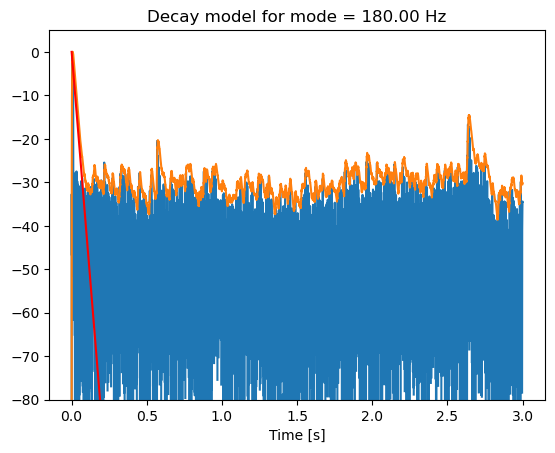

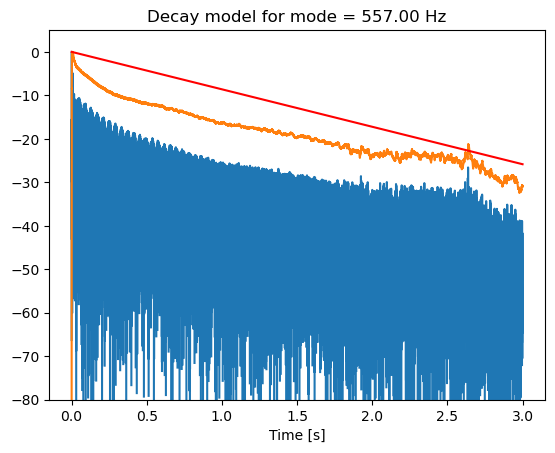

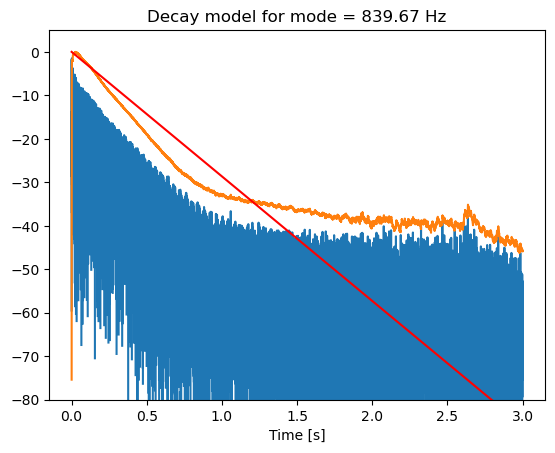

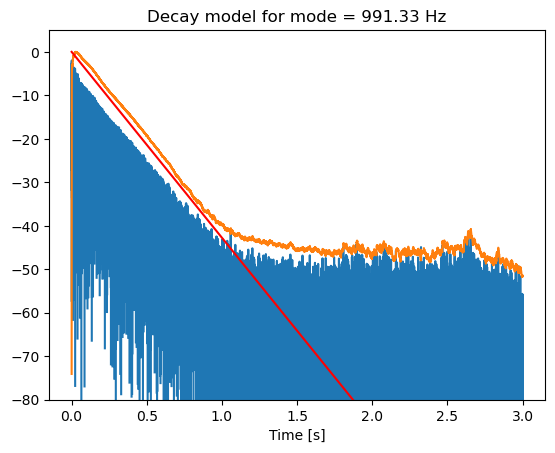

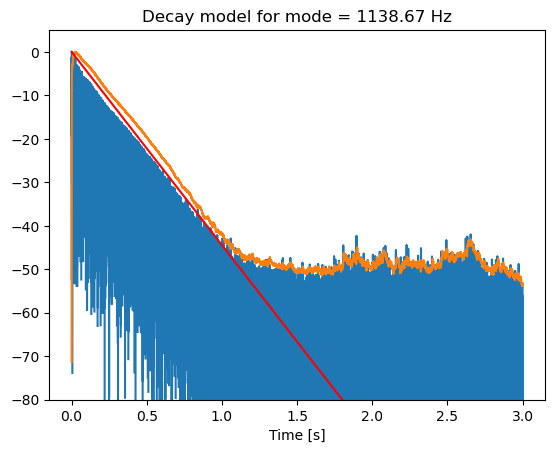

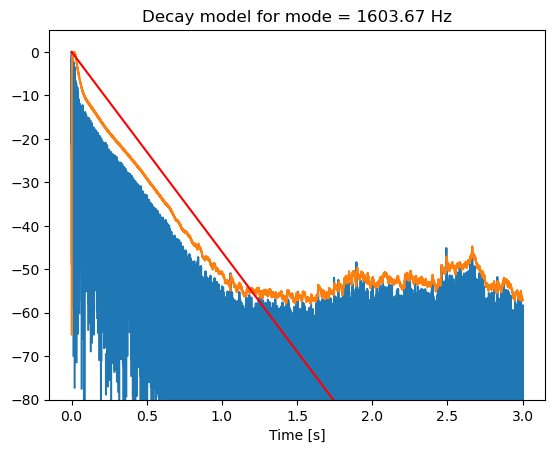

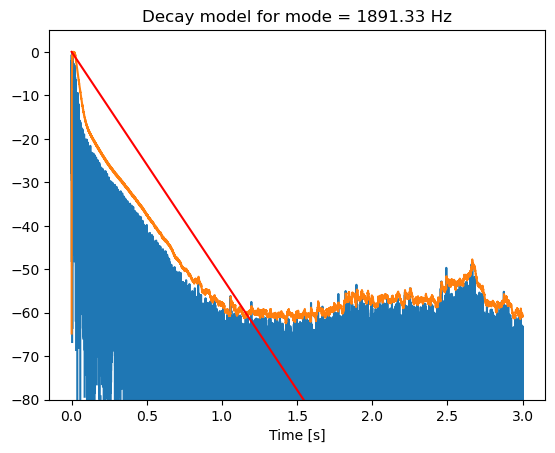

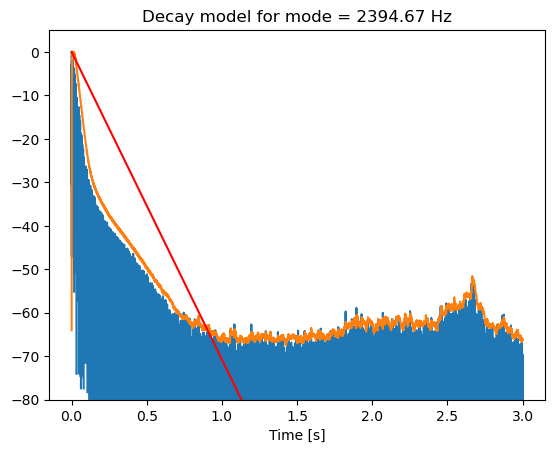

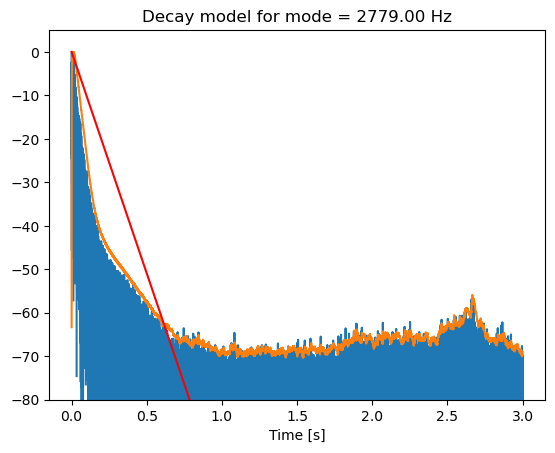

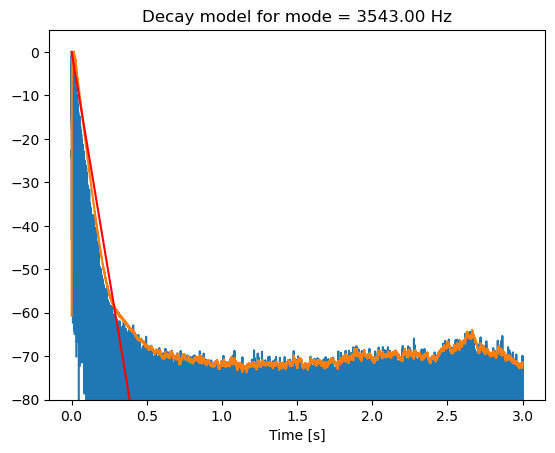

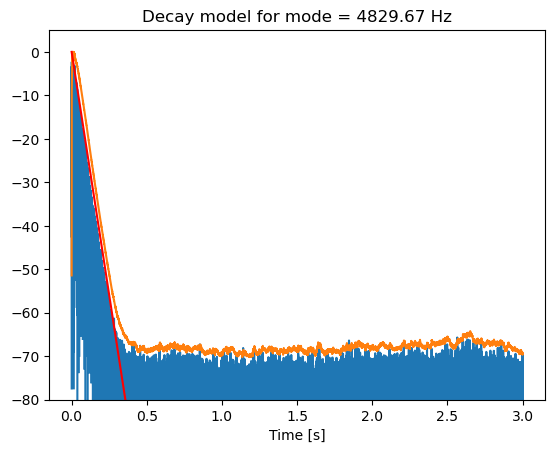

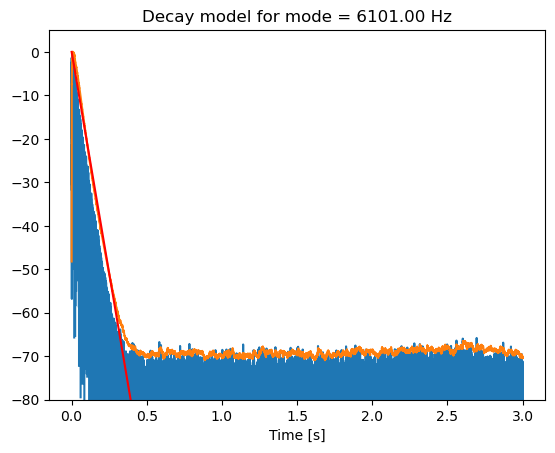

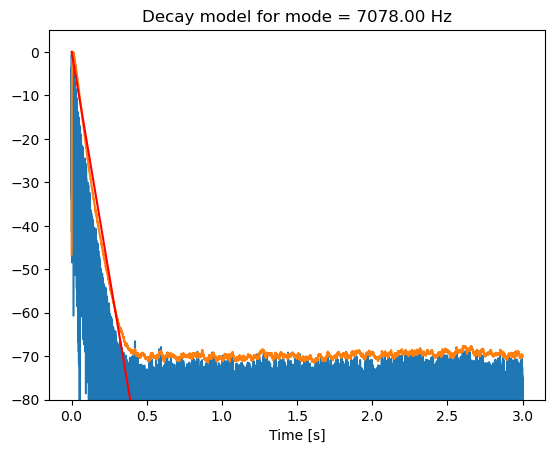

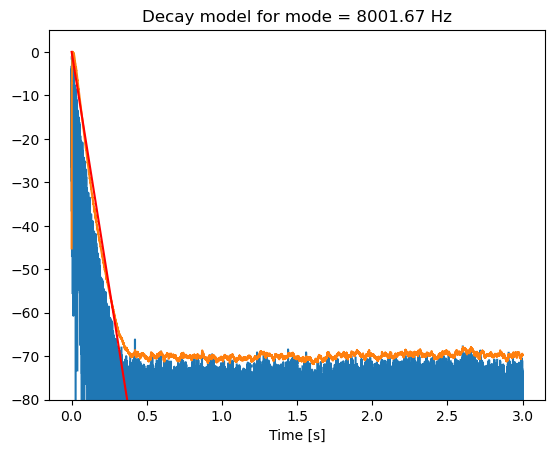

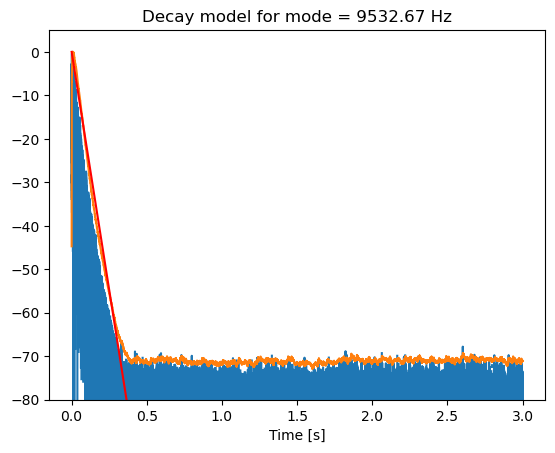

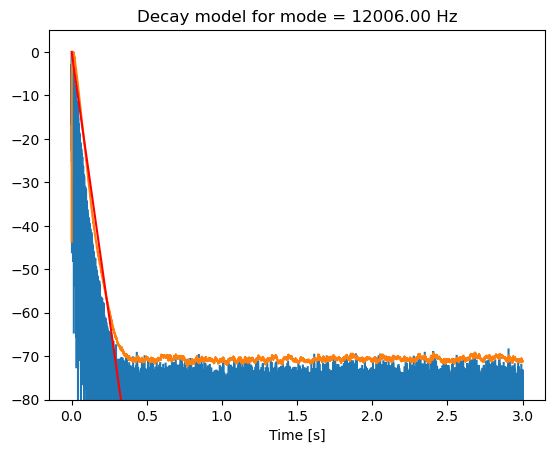

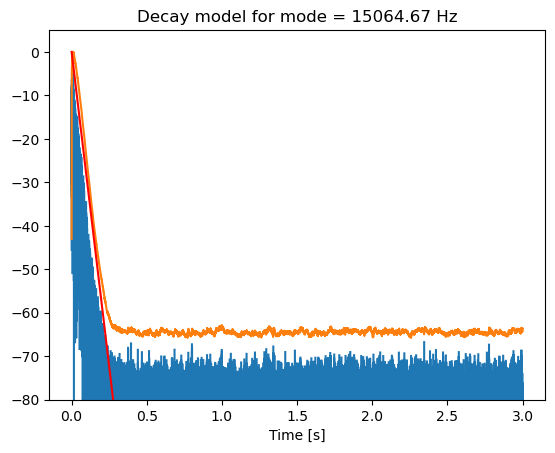

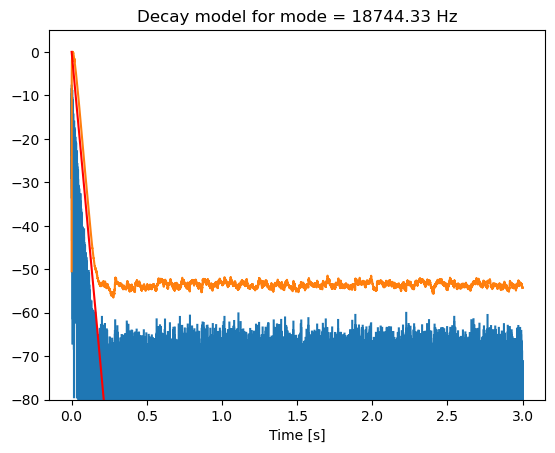

In [10]:
path = '/viscam/u/yenyu/ObjectFolderV2/objects/55/audio/real/random3.wav'
clip = wavio.read(path)
freqs = find_freqs(clip.data[:, 0], clip.rate, above=20, thresh=90, frac_off=0.1, plot=True)[0]
plt.show()
get_dampings(path, plot=True)
plt.show()

In [7]:
n_clips = 5
results_dict = {}
objects = [(55, 'Ceramic Tray'), (56, 'Ceramic Plate'), (59, 'Ceramic Pitcher'), (60, 'Ceramic Mug'), (22, 'Steel Bowl'), (23, 'Steel Mug'), (80, 'Steel Bundt')]

In [8]:
for el in objects:
    target_object = el[0]
    lambda_freqs = [None] * n_clips
    lambdas = [None] * n_clips
    for i in range(5):
        print(i)
        lambdas[i], lambda_freqs[i] = get_dampings('/viscam/u/yenyu/ObjectFolderV2/objects/%i/audio/real/random%i.wav'%(target_object, i))
    results_dict[target_object] = (lambda_freqs, lambdas)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


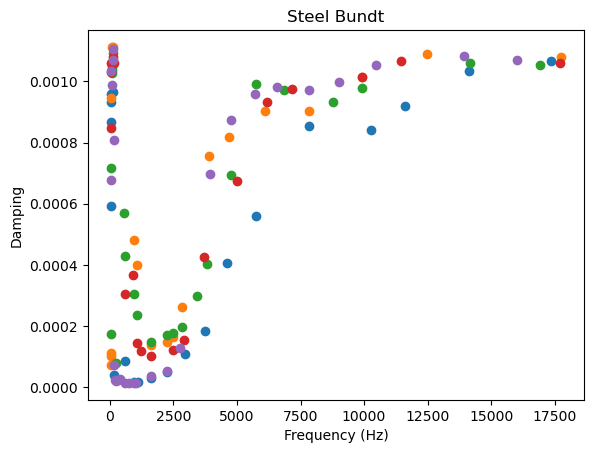

In [18]:
object_ind = 6
results = results_dict[objects[object_ind][0]]
for i in range(5):
    plt.scatter(results[0][i], results[1][i])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Damping')
plt.title(objects[object_ind][1])
plt.show()

In [ ]:
for i in range(4):
    

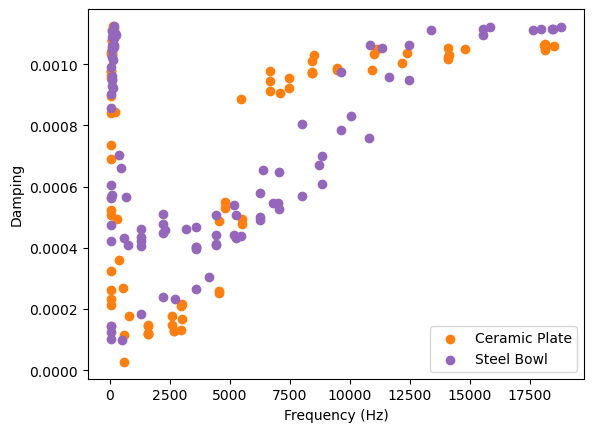

In [48]:
legend_entries = []
offset = 0
for i in [1,4]:#, t in enumerate(objects[offset:7]):
    t = objects[i]
    results = results_dict[t[0]]
    all_x = [item for sublist in results[0] for item in sublist]
    all_y = [item for sublist in results[1] for item in sublist]
    #for j in range(len(results[0])):
    plt.scatter(all_x, all_y, color='C%i'%(i+offset))
    legend_entries.append(t[1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Damping')
plt.legend(legend_entries)
plt.show()